In [1]:
import math
import os
import torch
import torch.nn.functional as F
from pytorch_pretrained_bert import GPT2Tokenizer, GPT2LMHeadModel
from BERT.bert import Ner
NER_model = Ner("BERT/model")
# Load pre-trained model (weights)
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.eval()
# Load pre-trained model tokenizer (vocabulary)
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')


In [16]:
def get_perplexity(story, model):
    """ returns the perplexity of an input string
        Args:
            story: input string
            model: model to calculate perplexity with
    """
    if isinstance(story, str):
        tokenize_input = tokenizer.encode(story)
        tensor_input = torch.tensor([tokenize_input])
    else:
        tensor_input = story
    loss=model(tensor_input, lm_labels=tensor_input)
    return math.exp(loss)

def generate(string, model):
    """ returns tensor of activations based on input string
        Args:
            string: input string
            model: model to generate output from
    """
    tokenize_input = tokenizer.encode(string)
    tensor_input = torch.tensor([tokenize_input])
    result, past = model(tensor_input)
    return result,past

In [3]:
def top_k_sampling(output, top_k=10, temperature=.8, filter_value=-float('Inf')):
    """ Filter a distribution of logits using top-k and/or nucleus (top-p) filtering
        Args:
            logits: raw output for the distribution size
            top_k >0: keep only top k tokens with highest probability (top-k filtering).
            temperature: Scaling for the logits
    """
    logits = F.softmax(output, dim=-1) / temperature
    top_k = min(top_k, logits.size(-1))  # Safety check
    
    if top_k > 0:
        # Remove all tokens with a probability less than the last token of the top-k
        indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
        logits[indices_to_remove] = filter_value
    
    #rescale distribution
    probs = F.softmax(logits, dim=-1)
    
    return torch.multinomial(probs, 1).T

In [4]:
EXAMPLE = 'It took a moment for me to catch the picture and see my reflection . I had no intention of seeing it , so I took a moment to appreciate it . The photo I had taken was the same one with the photo I had on my wedding day . I could have taken it out of that photo , and I could have been there . <newline> <newline> It felt so easy . <newline> <newline> I had to be careful , I thought as I sat down on the beach , my mind on the beach I was in . I had to know what would happen to me . I would be there with no way to know if it was my fault . I could have made sure it was alright . But I didn\'t . I had to know if it was alright toI sat there . My eyes were open . I sat there for hours , trying to make sense of the situation ; a situation where I had to get out of that situation . I just wanted to go home , to go home and watch TV , to do whatever I wanted . I wanted to go home , and I wanted to go home , to go home and go to my house . I wanted to leave , and that \'s all I needed , even to my own family . I got in the car , and the car started to slow down . It was going late ! I could hear people outside my window , but they were n\'t there , and they seemed to be coming to help me out . I started driving . It was going to be so slow. The rain poured down on the forest.'

In [27]:
#NER testing
sentence = "Steve went to Paris to buy bread. The French are odd."

output = NER_model.predict(sentence)

output #Named Entity Recognition output

[{'word': 'Steve', 'tag': 'B-PER', 'confidence': 0.9995656609535217},
 {'word': 'went', 'tag': 'O', 'confidence': 0.9999876022338867},
 {'word': 'to', 'tag': 'O', 'confidence': 0.999987006187439},
 {'word': 'Paris', 'tag': 'B-LOC', 'confidence': 0.9998935461044312},
 {'word': 'to', 'tag': 'O', 'confidence': 0.9999898672103882},
 {'word': 'buy', 'tag': 'O', 'confidence': 0.9999889135360718},
 {'word': 'bread', 'tag': 'O', 'confidence': 0.9999877214431763},
 {'word': '.', 'tag': 'O', 'confidence': 0.9999676942825317},
 {'word': 'The', 'tag': 'O', 'confidence': 0.9999814033508301},
 {'word': 'French', 'tag': 'B-MISC', 'confidence': 0.9997677206993103},
 {'word': 'are', 'tag': 'O', 'confidence': 0.9999867677688599},
 {'word': 'odd', 'tag': 'O', 'confidence': 0.99997878074646},
 {'word': '.', 'tag': 'O', 'confidence': 0.999968409538269}]

In [6]:
def get_mask(sentence, model, length):
    """ Returns the boolean mask for a string of text, 1 indicates a named entity
        Args:
            sentence: string to be turned into an NER mask
                [{word:token, tag:tag, confidence:probability}] - NER output
    """
    mask = []
    NER_output = model.predict(sentence)
    for word in NER_output:
        if word['tag'] != 'O' and word['confidence'] > .9:
            mask.append(1)
        else:
            mask.append(0)
    while len(mask) < length:
        mask.append(0)
    return torch.tensor([mask])
mask = get_mask(sentence, NER_model, 8)
mask

tensor([[1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]])

In [30]:
get_perplexity(EXAMPLE, model)

13.284974798899672

In [21]:
def rewrite(string, model, topk=10):
    """ Rewrites an input string by predicting one word at a time. Uses top_k_sampling
        and generates based on the history of the words in the string
        Args:
            string: the input string or tensor of tokne indices
            model: Model used to generate the predictions
            topk: number of words to include in top_k sampling
    """
    if isinstance(string, str):
        words = torch.tensor([tokenizer.encode(string)])
    else:
        words = string
    new_tokens = []
    res, past = model(words)
    for i in range(words.shape[1]):
        token = top_k_sampling(res[0,i,:], topk)
        new_tokens.append(token)
    return torch.cat(new_tokens)

In [28]:
#This rewrites the non-named entities one word at a time based on the mask
mask = get_mask(sentence, NER_model, 13)
test = torch.tensor([tokenizer.encode(sentence)])
masked = mask * test
unmask = 1-mask
new_tokens = rewrite(sentence, model)
output = masked + (unmask*new_tokens)
output

tensor([[19206,   284,   262,  6342,   766,  8587,    11,   679,   717,  4141,
           407,    13,   314]])

In [29]:
#Gibbs sampling new tokens at increasingly small amounts
#to avoid confusing sentences
words = output.numpy()[0]
for i in range(len(words)):
    print(tokenizer.decode([words[i]]))

Steve
 to
 the
 Paris
 see
 tickets
,
 He
 first
 French
 not
.
 I


In [46]:
def Gibbs(story, model, NER_model, tokenizer, max_prob=.05, min_prob=.001, frac=.8):
    """ Performs Gibbs sampling procedure on a story in an attempt to improve the perplexity
        Args:
            story: input story, string
            model: model to do the rewriting (currently GPT2)
            NER_model: model to perform NER (currently BERT-NER)
            tokenizer: tokenizer (GPT2 tokenizer currently)
            max_prob: maximum probability of rewriting non-named-entity tokens
            min_prob: minimum probability
            frac: fraction of time spent above minimum probability
    """
    perplexities = []
    iter_tensor = torch.tensor([tokenizer.encode(story)])
    length = iter_tensor.shape[1]
    N = length*5
    orig_mask = get_mask(story, NER_model, length)
    best_perplexity = get_perplexity(story, model)
    perplexities.append(best_perplexity)
    for n in range(N):
        #compute new masks
        new_prob = max_prob - (n*(max_prob - min_prob)/(frac*N))
        new_prob = max(min_prob, new_prob)
        new_mask = torch.rand(length) > new_prob
        new_mask = new_mask.type(torch.int8)
        new_mask = torch.logical_or(orig_mask, new_mask).type(torch.int8)
        mask_comp = 1 - new_mask
        #tensor of kept tokens
        masked = iter_tensor * new_mask
        
        #rewrite input
        new_tokens = rewrite(iter_tensor, model, 5)
        output = masked + (mask_comp * new_tokens)
        
        #prepare for next iteration
        try:
            perplex = get_perplexity(output, model)
            perplexities.append(perplex)
            print(new_prob, perplex)
            iter_tensor = output
            #if perplex < best_perplexity:
                #iter_tensor = output
        except Exception as e:
            print(f'error with string on iter {n}', e)
        
        output = tokenizer.decode(iter_tensor.numpy()[0])
        
    return output, perplexities

story, perplexities = Gibbs(sentence, model, NER_model, tokenizer)

0.05 86.73084284508542
0.04905769230769231 86.73084284508542
0.048115384615384615 86.73084284508542
0.04717307692307693 86.73084284508542
0.046230769230769235 138.49804747502287
0.04528846153846154 222.41167319138776
0.04434615384615385 222.41167319138776
0.043403846153846154 360.9829263458948
0.04246153846153847 590.7162214400677
0.041519230769230774 590.7162214400677
0.04057692307692308 765.0551259038351
0.039634615384615386 765.0551259038351
0.03869230769230769 798.6104253317208
0.037750000000000006 798.6104253317208
0.036807692307692305 798.6104253317208
0.03586538461538462 692.1264677828543
0.034923076923076925 692.1264677828543
0.03398076923076923 1371.1726116441846
0.033038461538461544 1371.1726116441846
0.032096153846153844 1371.1726116441846
0.031153846153846157 1371.1726116441846
0.030211538461538463 2009.204240408005
0.02926923076923077 2009.204240408005
0.02832692307692308 2009.204240408005
0.027384615384615386 2009.204240408005
0.026442307692307692 2009.204240408005
0.0255

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

<IPython.core.display.Javascript object>


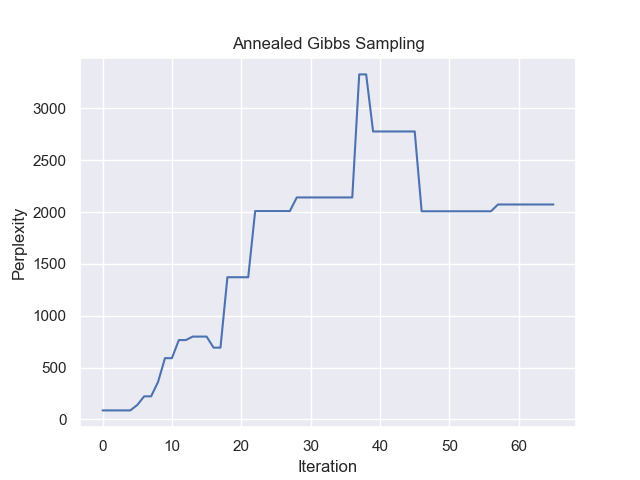

In [48]:
%matplotlib notebook
plt.figure()
plt.plot(range(len(perplexities)), perplexities)
plt.title('Annealed Gibbs Sampling')
plt.xlabel('Iteration')
plt.ylabel('Perplexity')
plt.show()